In [1]:
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip, SigmaClip
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import gaussian_fwhm_to_sigma

from photutils.background import Background2D, MedianBackground, StdBackgroundRMS
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog

import matplotlib.pyplot as plt

In [2]:
cosmos_xid16 = Table.read('/mnt/g/data/SR/dmu26_XID+SPIRE_COSMOS_20161129.fits')

# Read cosmos_xid24 and remove any columns that contain posterior distibutions 'Post_'
cosmos_xid24 = Table.read('/mnt/g/data/SR/Master_Post_Catalogue_MIPS_PACS_SPIRE_SCUBA.fits')
cols_to_drop = [col for col in cosmos_xid24.colnames if 'Post_' in col]
if cols_to_drop:
    cosmos_xid24.remove_columns(cols_to_drop)
    
cosmos_xid21 = Table.read('/mnt/g/data/SR/dmu26_XID+SPIRE_COSMOS_20210729.fits')

cosmos_xid16_df = cosmos_xid16.to_pandas()
cosmos_xid21_df = cosmos_xid21.to_pandas()
cosmos_xid24_df = cosmos_xid24.to_pandas()

In [16]:
cosmos_xid24_df['Bkg_250']

0              NaN
1              NaN
2         1.187788
3              NaN
4        -1.046316
            ...   
131173   -1.953364
131174   -3.199500
131175   -2.980536
131176   -3.244086
131177   -1.219604
Name: Bkg_250, Length: 131178, dtype: float32

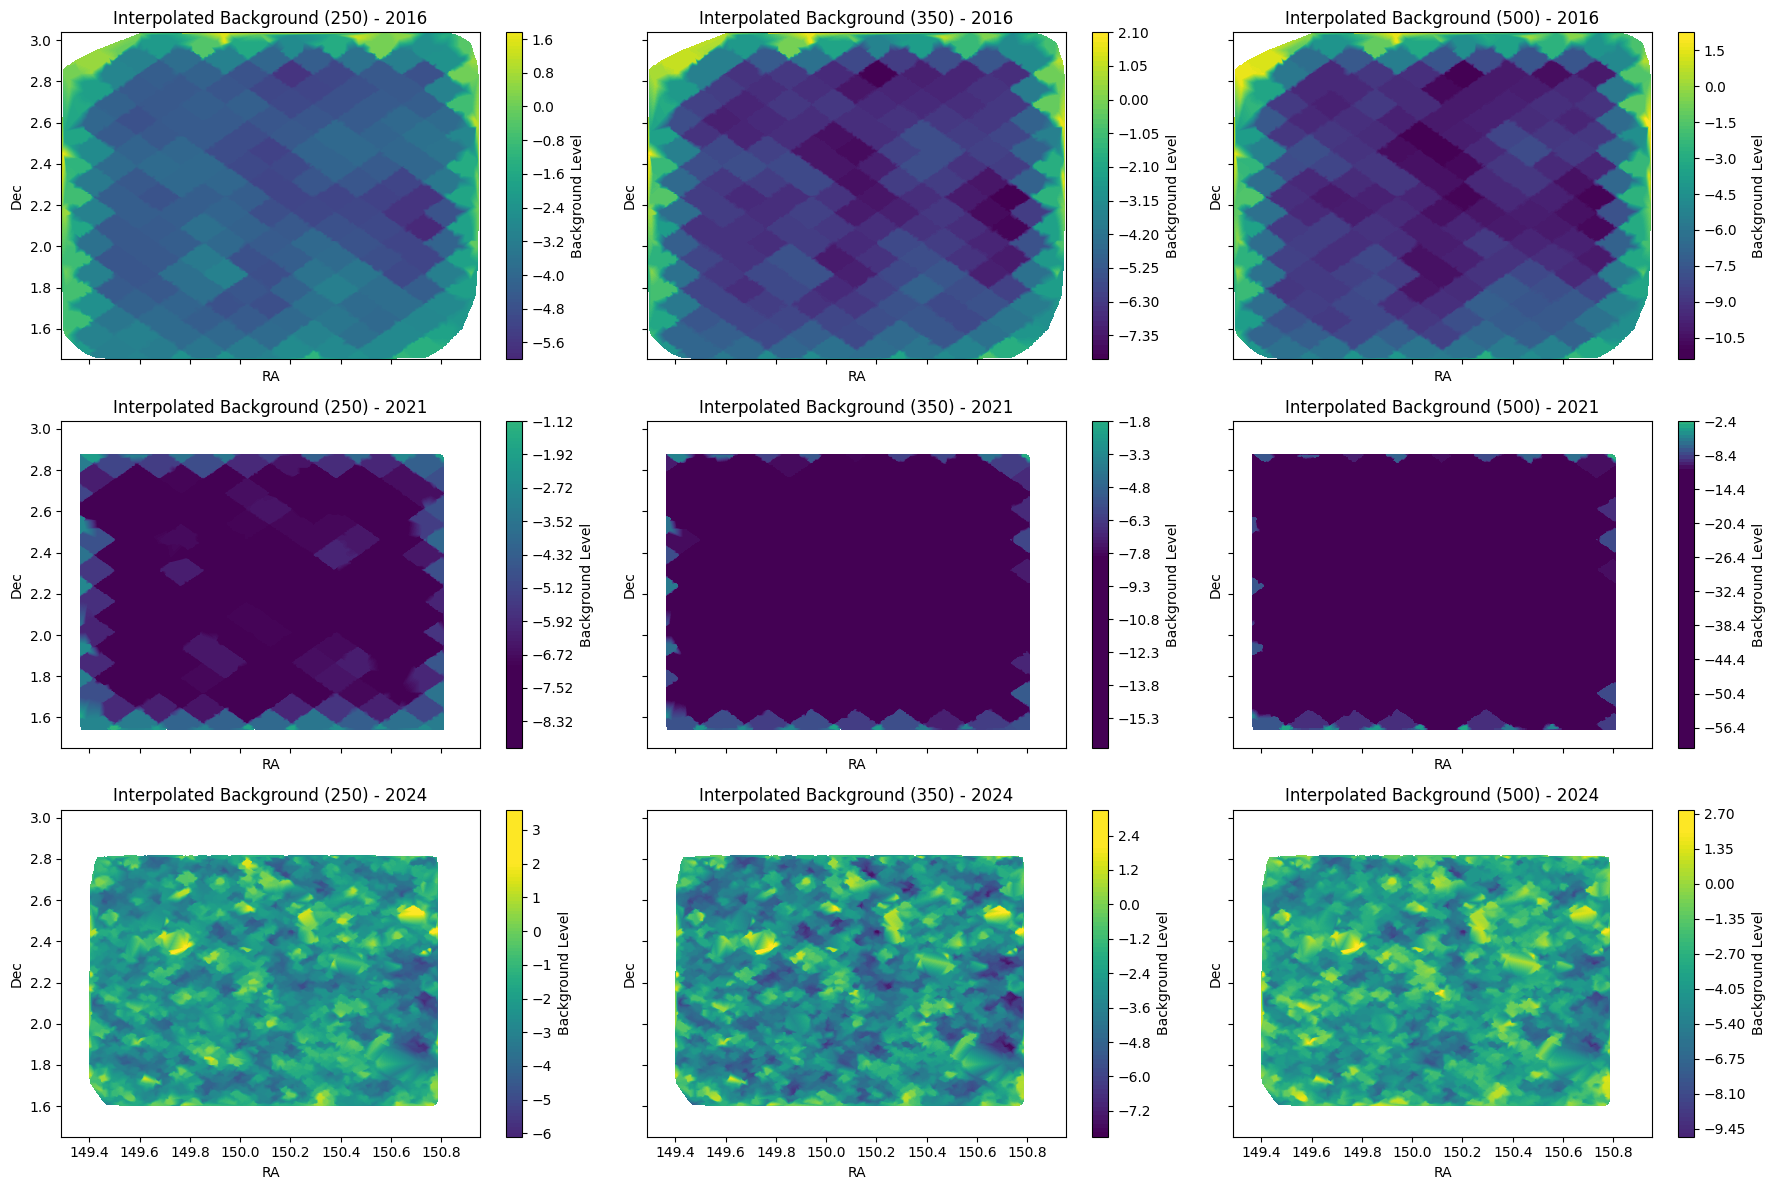

In [45]:
from scipy.interpolate import griddata


data_versions = [('2016', cosmos_xid16_df), ('2021', cosmos_xid21_df), ('2024', cosmos_xid24_df)]
bands = ['Bkg_SPIRE_250', 'Bkg_SPIRE_350', 'Bkg_SPIRE_500']

def get_col(band, version):
    if version == '2024':
        return band.replace('Bkg_SPIRE', 'Bkg')
    else:
        return band

fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)

for i, (version, df) in enumerate(data_versions):
    for j, band in enumerate(bands):
        ax = axes[i, j]
        x = df['RA'].values
        y = df['Dec'].values
        z = df[get_col(band, version)].values

        mask = ~np.isnan(z)
        x_valid = x[mask]
        y_valid = y[mask]
        z_valid = z[mask]

        ngrids= 500
        xi = np.linspace(x.min(), x.max(), ngrids)
        yi = np.linspace(y.min(), y.max(), ngrids)
        xi, yi = np.meshgrid(xi, yi)

        zi = griddata((x_valid, y_valid), z_valid, (xi, yi), method='linear')

        if j == 0:
            vmin, vmax = -7, 2
        elif j == 1:
            vmin, vmax = -8, 2
        else:
            vmin, vmax = -11, 2
        cp = ax.contourf(xi, yi, zi, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.set_title(f'Interpolated Background ({band.split("_")[-1]}) - {version}')
        fig.colorbar(cp, ax=ax, label='Background Level')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

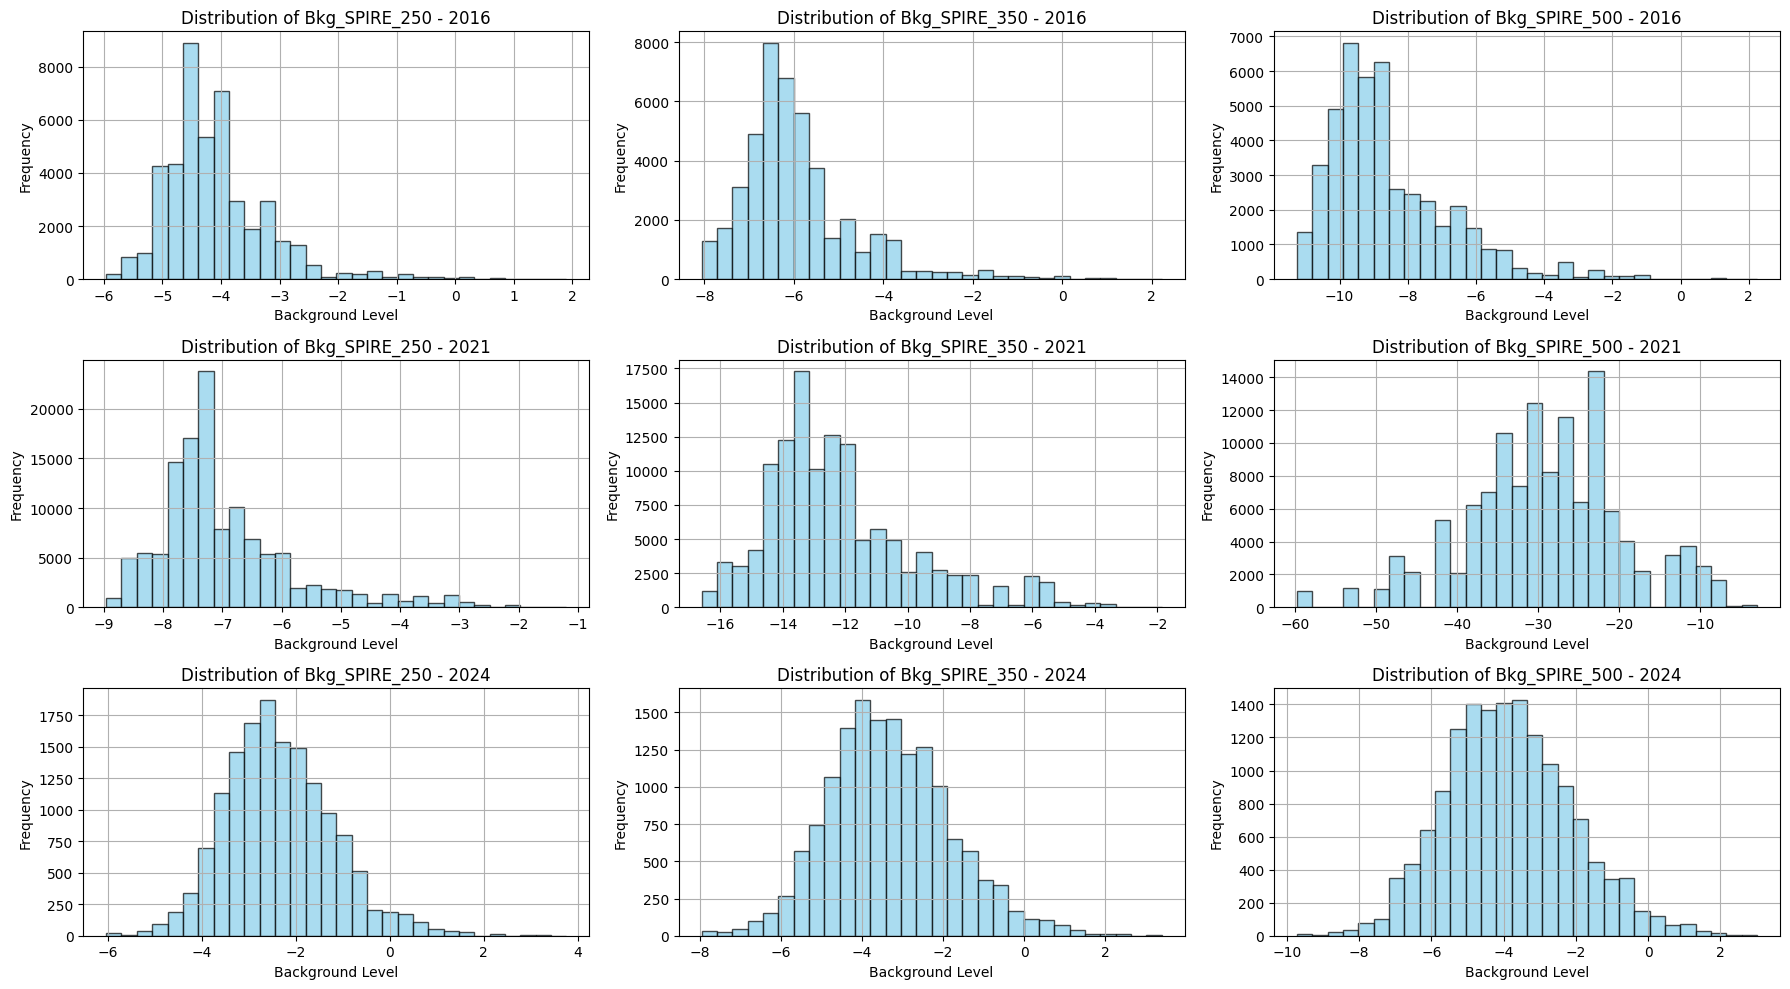

In [4]:
plt.figure(figsize=(10, 6))
data_versions = [('2016', cosmos_xid16_df), ('2021', cosmos_xid21_df), ('2024', cosmos_xid24_df)]
bands = ['Bkg_SPIRE_250', 'Bkg_SPIRE_350', 'Bkg_SPIRE_500']

fig, axes = plt.subplots(len(data_versions), len(bands), figsize=(18, 10))

for i, (version, df) in enumerate(data_versions):
    for j, band in enumerate(bands):
        ax = axes[i, j]
        ax.hist(df[get_col(band, version)], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {band} - {version}')
        ax.set_xlabel('Background Level')
        ax.set_ylabel('Frequency')
        ax.grid(True)

plt.tight_layout()
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        3692

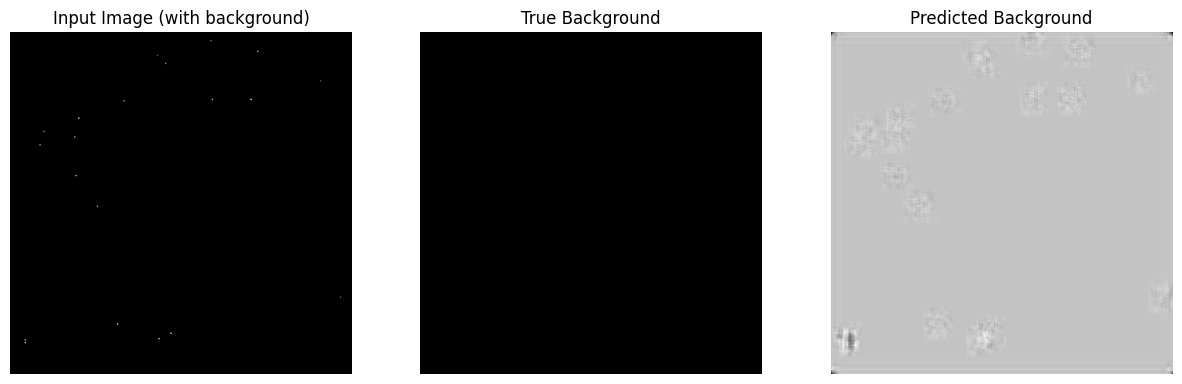

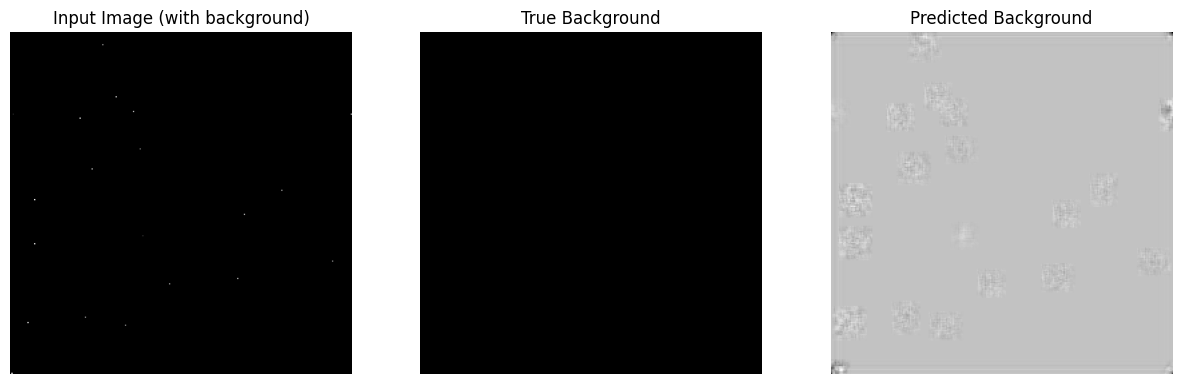

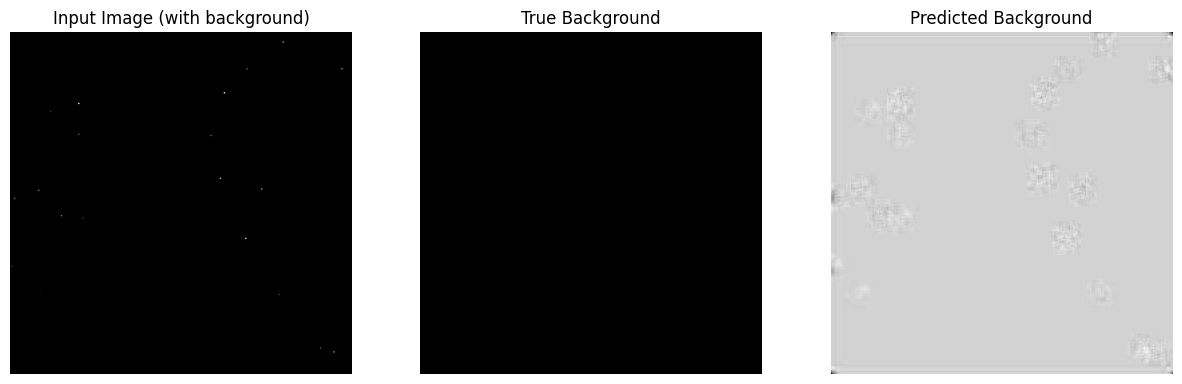

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
from tensorflow.keras import layers, models

# ----------------------------------------------------------
# 1. Data Augmentation: Add Background to Simulated Images
# ----------------------------------------------------------

def add_constant_background(image, low=10, high=50):
    """
    Adds a constant background value drawn uniformly between low and high.
    """
    background_value = np.random.uniform(low, high)
    return image + background_value, np.zeros(image.shape) + background_value

def add_patch_background(image, n_patches=3, patch_size=50, low=10, high=50):
    """
    Adds small patches with constant background to the image.
    Each patch has a constant value drawn from a uniform distribution.
    """
    # Create an empty background image (same shape as input)
    background = np.zeros_like(image)
    H, W = image.shape
    
    for _ in range(n_patches):
        # Random constant for this patch
        patch_val = np.random.uniform(low, high)
        # Random top-left position, ensuring the patch fits within the image
        top = np.random.randint(0, H - patch_size)
        left = np.random.randint(0, W - patch_size)
        background[top:top+patch_size, left:left+patch_size] += patch_val
    # The new image is original image plus background patches
    return image + background, background

# Example: simulate a clean image and add background
def simulate_image(shape=(256, 256)):
    """
    Simulate a clean astronomical image.
    For simplicity, we generate an image with random stars (bright spots) on a dark background.
    """
    image = np.zeros(shape)
    # simulate a few stars
    num_stars = 20
    for _ in range(num_stars):
        y = np.random.randint(0, shape[0])
        x = np.random.randint(0, shape[1])
        intensity = np.random.uniform(100, 1000)
        image[y, x] = intensity
    return image

# Generate a sample dataset (here, just for demonstration)
num_samples = 1000
images = []
backgrounds = []

for i in range(num_samples):
    clean = simulate_image()
    # Choose one of the background addition methods randomly:
    if np.random.rand() < 0.5:
        aug_image, bg = add_constant_background(clean)
    else:
        aug_image, bg = add_patch_background(clean)
    images.append(aug_image)
    backgrounds.append(bg)  # true background image

# Convert to numpy arrays and add channel dimension for Keras (assuming grayscale images)
images = np.expand_dims(np.array(images), axis=-1)  # shape: (num_samples, 256, 256, 1)
backgrounds = np.expand_dims(np.array(backgrounds), axis=-1)

# ----------------------------------------------------------
# 2. Setup a Simple Neural Network for Background Estimation
# ----------------------------------------------------------
def build_simple_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2))(x)
    
    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Output layer: same dimensions as input with linear activation for regression
    outputs = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_simple_model()
model.summary()

# ----------------------------------------------------------
# 3. Train the Model
# ----------------------------------------------------------
# For demonstration, we use a small number of epochs.
history = model.fit(images, backgrounds, epochs=50, batch_size=64, validation_split=0.1)

# ----------------------------------------------------------
# 4. Visualization Tool to Show Accuracy
# ----------------------------------------------------------
def visualize_predictions(model, images, true_backgrounds, num_examples=3):
    """
    Visualize the input image, true background, and predicted background.
    """
    preds = model.predict(images)
    
    indices = np.random.choice(len(images), num_examples, replace=False)
    for i in indices:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i].squeeze(), cmap='gray')
        axs[0].set_title("Input Image (with background)")
        axs[1].imshow(true_backgrounds[i].squeeze(), cmap='gray')
        axs[1].set_title("True Background")
        axs[2].imshow(preds[i].squeeze(), cmap='gray')
        axs[2].set_title("Predicted Background")
        for ax in axs:
            ax.axis('off')
        plt.show()

# Visualize some predictions on the training set (or you can use a separate test set)
visualize_predictions(model, images, backgrounds)


32/32 [==============================] - 0s 13ms/step


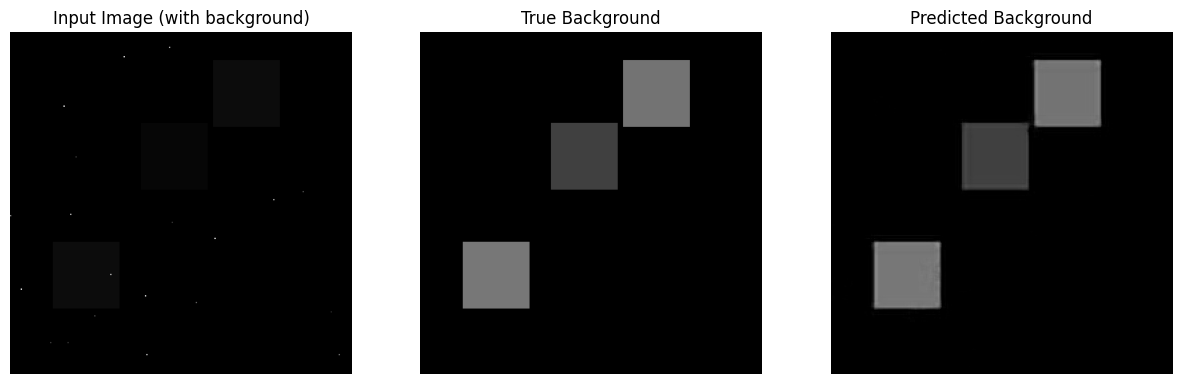

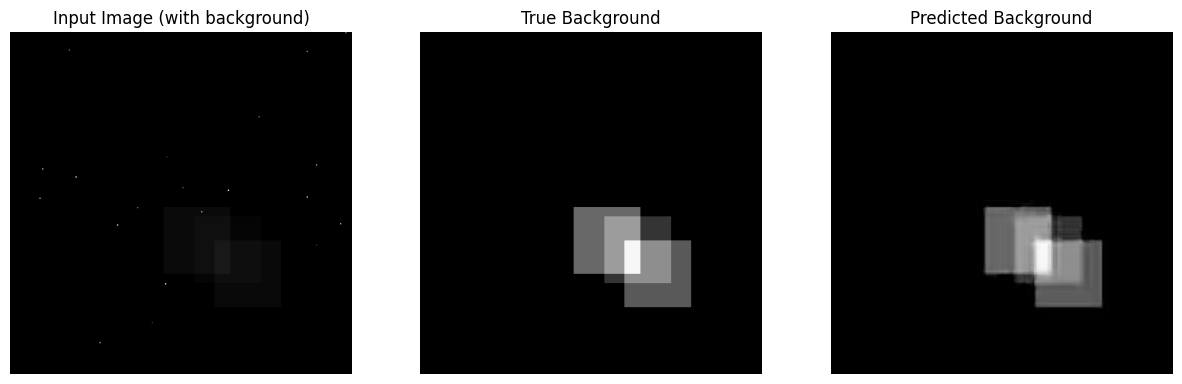

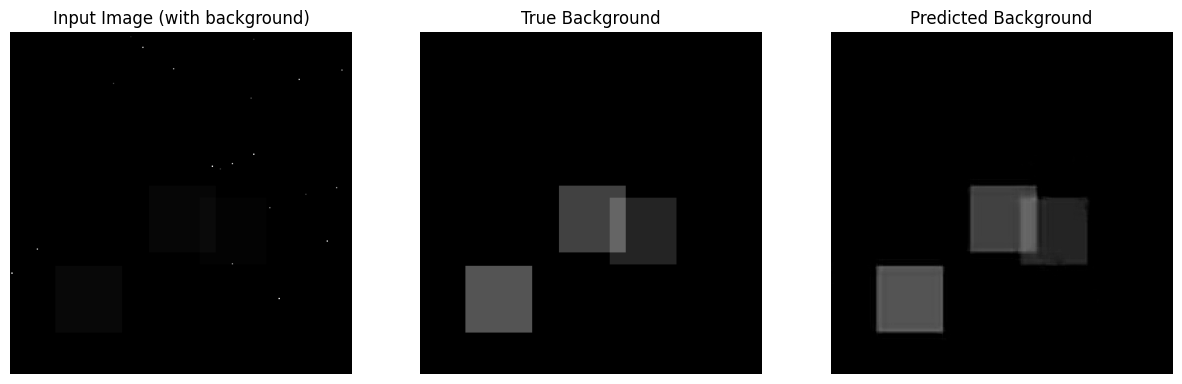

In [34]:
def visualize_predictions(model, images, true_backgrounds, num_examples=3):
    """
    Visualize the input image, true background, and predicted background.
    """
    preds = model.predict(images)
    
    indices = np.random.choice(len(images), num_examples, replace=False)
    for i in indices:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i].squeeze(), cmap='gray')
        axs[0].set_title("Input Image (with background)")
        axs[1].imshow(true_backgrounds[i].squeeze(), cmap='gray', vmin=0, vmax=100)
        axs[1].set_title("True Background")
        axs[2].imshow(preds[i].squeeze(), cmap='gray', vmin=0, vmax=100)
        axs[2].set_title("Predicted Background")
        for ax in axs:
            ax.axis('off')
        plt.show()

# Visualize some predictions on the training set (or you can use a separate test set)
visualize_predictions(model, images, backgrounds)